In [135]:
#!/usr/bin/env python

# data tools
import os, cv2, glob, argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# tf tools
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Conv2D,
                                     MaxPool2D,
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten,
                                     Dropout,
                                     Dense)
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)

In [136]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")])

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [137]:
height = 224
width = 224

def read_data(filepath):
    # Info for terminal
    print(f"[INFO] Loading images: \"{filepath}\" ...")
    
    # Empty list for appending to
    X = []
    
    # For each file read and append to list
    for img in glob.glob(os.path.join(filepath, "*.jpg")):
        X.append(cv2.imread(img))
    
    # Create label, based on folder origin
    y = [f"{os.path.split(filepath)[1]}"] * len(X)
    
    # Return labels and images
    return X, y

# Define function for resizing and making into array
def get_resized_arrays(arrays, width, height):
    # Info for terminal use
    print("[INFO] Resizing images ...")
    
    # Empty list for appending to
    arrays_resized = []
    
    # For every array in the list of arrays
    for array in arrays:
        # Resize array
        resized = cv2.resize(array, (width, height), interpolation = cv2.INTER_AREA)
        
        # Convert to array and values between 0 and 1 to allow to be used in CNN (using list comprehension)
        resized = np.asarray(resized/255.).astype("float32")

        # Append to list
        arrays_resized.append(resized)

    # Return
    return arrays_resized

def plot_history(H, epochs):
    """
    Function which plots accuracy and loss over epochs
    """
    # Make a list of epochs
    epochs_range = range(epochs)
    
    # Create a plot showing accuracies
    plt.figure(figsize = (15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, H.history['accuracy'], label='Training accuracy')
    plt.plot(epochs_range, H.history['val_accuracy'], label='Validation accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')

    # Create a plot showing loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, H.history['loss'], label='Training loss')
    plt.plot(epochs_range, H.history['val_loss'], label='Validation loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(os.path.join("out", 'training_history.png'), format='png', dpi=100)

In [138]:
X = []
y = []

for i in ["content_monet_style_monet", "content_cezanne_style_cezanne", "content_cezanne_style_monet", "content_monet_style_cezanne"]:
    X_new, y_new = read_data(os.path.join("data", f"{i}"))
    
    X.extend(X_new)
    y.extend(y_new)

[INFO] Loading images: "data/content_monet_style_monet" ...
[INFO] Loading images: "data/content_cezanne_style_cezanne" ...
[INFO] Loading images: "data/content_cezanne_style_monet" ...
[INFO] Loading images: "data/content_monet_style_cezanne" ...


In [139]:
# Resize arrays to fit input dimensions
X = get_resized_arrays(X, 224, 224)

[INFO] Resizing images ...


In [140]:
print(type(X), len(X), type(X[0]), X[0].shape)
print(type(y), len(y), type(y[0]), y[0])
set(y)

<class 'list'> 1989 <class 'numpy.ndarray'> (224, 224, 3)
<class 'list'> 1989 <class 'str'> content_monet_style_monet


{'content_cezanne_style_cezanne',
 'content_cezanne_style_monet',
 'content_monet_style_cezanne',
 'content_monet_style_monet'}

In [141]:
# Create dataframe with labels and arrays
df = pd.DataFrame.from_dict({"X" : X, "y" : y})

In [142]:
# Create dataframe with subset
df_orig = df.loc[(df['y'] == "content_monet_style_monet") | (df['y'] == "content_cezanne_style_cezanne")]

In [179]:
# Define X and y,
X = list(df_orig["X"])
y = list(df_orig["y"])

In [180]:
#Get labelnames
label_names = set(y)
label_names

{'content_cezanne_style_cezanne', 'content_monet_style_monet'}

In [181]:
# Right format for X
X = np.array(X).reshape(len(X), width, height, 3)

In [182]:
# Right format for y
lb = LabelEncoder()
y = lb.fit_transform(y)
y = y.reshape(-1,1)
enc = OneHotEncoder()
y = enc.fit_transform(y).toarray()

In [147]:
# Make a test-train split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 9, # for replication purposes
                                                    train_size = .8)

In [148]:
print(type(X_train), len(X_train), type(X_train[0]), X_train[0].shape)
print(type(y_train), type(y_train[0]), y_train[0])

<class 'numpy.ndarray'> 796 <class 'numpy.ndarray'> (224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> [1. 0.]


In [149]:
print(type(X_train), len(X_train), type(X_train[0]), X_train[0].shape)
print(type(y_train), len(y_train), type(y_train[0]), y_train[0])

<class 'numpy.ndarray'> 796 <class 'numpy.ndarray'> (224, 224, 3)
<class 'numpy.ndarray'> 796 <class 'numpy.ndarray'> [1. 0.]


In [150]:
history = model.fit(X_train, y_train, 
              validation_data=(X_test, y_test), 
              batch_size = 32,
              epochs = 5)

Epoch 1/5
25/25 [==============================] - 10s 311ms/step - loss: 0.7328 - accuracy: 0.5653 - val_loss: 0.3968 - val_accuracy: 0.8693
Epoch 2/5
25/25 [==============================] - 7s 288ms/step - loss: 0.3774 - accuracy: 0.8703 - val_loss: 0.2850 - val_accuracy: 0.9095
Epoch 3/5
25/25 [==============================] - 7s 272ms/step - loss: 0.2862 - accuracy: 0.8998 - val_loss: 0.2552 - val_accuracy: 0.9196
Epoch 4/5
25/25 [==============================] - 7s 263ms/step - loss: 0.2786 - accuracy: 0.8979 - val_loss: 0.2165 - val_accuracy: 0.9397
Epoch 5/5
25/25 [==============================] - 7s 263ms/step - loss: 0.2288 - accuracy: 0.9309 - val_loss: 0.2014 - val_accuracy: 0.9397


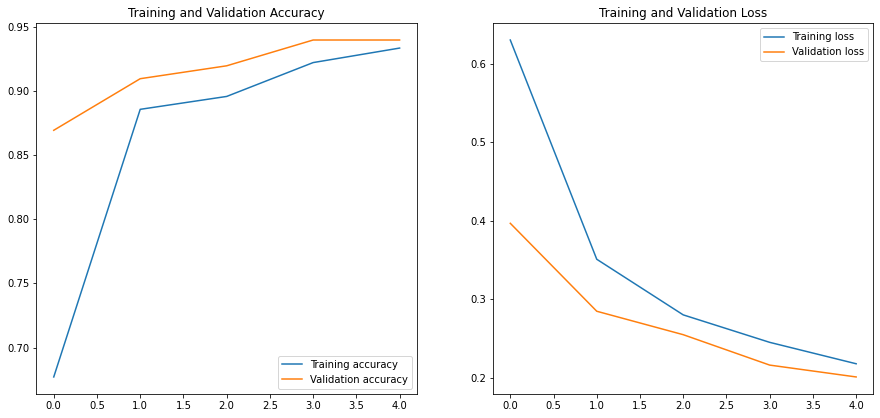

<Figure size 432x288 with 0 Axes>

In [151]:
plot_history(history, 5)

In [152]:
predictions = model.predict(X_test,
         batch_size = 32)

In [153]:
predictions[0]

array([0.88457495, 0.11542513], dtype=float32)

In [154]:
classif_report = pd.DataFrame(classification_report(y_test.argmax(axis=1),
                                predictions.argmax(axis=1),
                                target_names = label_names, output_dict = True))

In [155]:
classif_report

,content_monet_style_monet,content_cezanne_style_cezanne,accuracy,macro avg,weighted avg
precision,0.932039,0.947917,0.939698,0.939978,0.939858
recall,0.950495,0.928571,0.939698,0.939533,0.939698
f1-score,0.941176,0.938144,0.939698,0.939660,0.939683
support,101.000000,98.000000,0.939698,199.000000,199.000000


In [198]:
content_monet_style_cezanne = df.loc[(df['y'] == "content_monet_style_cezanne")]

In [199]:
X = list(content_monet_style_cezanne["X"])
y = list(content_monet_style_cezanne["y"])

In [200]:
# Right format for X
X_test = np.array(X).reshape(len(X), width, height, 3)
# Right format for y
lb = LabelEncoder()
y = lb.fit_transform(y)
y = y.reshape(-1,1)
y_test = enc.transform(y).toarray()

In [201]:
predictions = model.predict(X_test,
         batch_size = 32)

In [202]:
predictions[0]

array([9.9936634e-01, 6.3362799e-04], dtype=float32)

In [203]:
classif_report = pd.DataFrame(classification_report(y_test.argmax(axis=1),
                                predictions.argmax(axis=1),
                                target_names = label_names, output_dict = True))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [204]:
classif_report

,content_monet_style_monet,content_cezanne_style_cezanne,accuracy,macro avg,weighted avg
precision,1.000000,0.0,0.690141,0.500000,1.000000
recall,0.690141,0.0,0.690141,0.345070,0.690141
f1-score,0.816667,0.0,0.690141,0.408333,0.816667
support,497.000000,0.0,0.690141,497.000000,497.000000


In [205]:
df_stylized = df.loc[(df['y'] == "content_monet_style_cezanne") | (df['y'] == "content_cezanne_style_monet")]
df_stylized = df_styliz.replace(['content_monet_style_cezanne'],'content_monet_style_monet')
df_stylized = df_styliz.replace(['content_cezanne_style_monet'],'content_cezanne_style_cezanne')

/usr/local/lib/python3.6/dist-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [206]:
X = list(df_stylized["X"])
y = list(df_stylized["y"])

In [207]:
# Right format for X
X_test = np.array(X).reshape(len(X), width, height, 3)
# Right format for y
lb = LabelEncoder()
y = lb.fit_transform(y)
y = y.reshape(-1,1)
y_test = enc.transform(y).toarray()

In [208]:
predictions = model.predict(X_test,
         batch_size = 32)

In [209]:
predictions[0]

array([0.47369775, 0.5263022 ], dtype=float32)

In [210]:
classif_report = pd.DataFrame(classification_report(y_test.argmax(axis=1),
                                predictions.argmax(axis=1),
                                target_names = label_names, output_dict = True))

In [211]:
classif_report

,content_monet_style_monet,content_cezanne_style_cezanne,accuracy,macro avg,weighted avg
precision,0.227477,0.280000,0.256539,0.253739,0.253739
recall,0.203219,0.309859,0.256539,0.256539,0.256539
f1-score,0.214665,0.294174,0.256539,0.254420,0.254420
support,497.000000,497.000000,0.256539,994.000000,994.000000
